In [67]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [68]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)

In [69]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

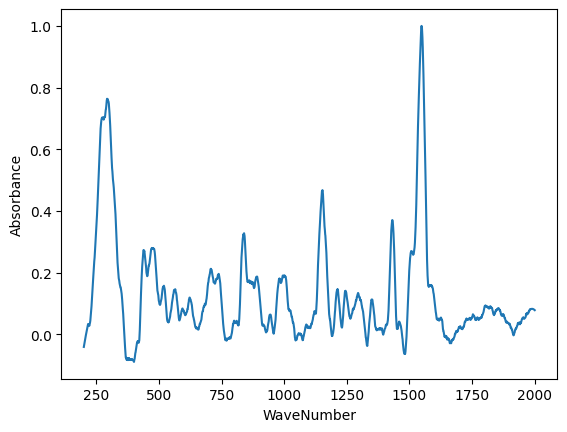

In [70]:
sample = df[df['SpecID'] == "210526-3-06"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [71]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,0.584637
1,201210-1-00,1,200.68336,201210-1,Normal,0.576621
2,201210-1-00,2,201.36674,201210-1,Normal,0.568924
3,201210-1-00,3,202.05011,201210-1,Normal,0.561545
4,201210-1-00,4,202.73349,201210-1,Normal,0.554483
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,0.093663
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,0.095611
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,0.097670
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,0.099838


In [72]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [73]:
pivot_df = prepare_wavelength_df(df, 'Absorbance')

In [74]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(pivot_df, test_size=0.2, random_state=1234)

In [91]:
test = test.reset_index()

In [93]:
test = test[['SpecID', 'Status']]

In [95]:
test.to_csv("../../data/graph_2_0/test/nodes.csv", index=False)

# Train

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = train.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 5 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
train_kernel_df = pd.DataFrame(kernel_matrix, index=train.index, columns=train.index)

# Full

In [76]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivot_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [77]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 5 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivot_df.index, columns=pivot_df.index)

In [78]:
kernel_matrix

array([[1.        , 0.63272119, 0.13789299, ..., 0.35462102, 0.32392219,
        0.35154012],
       [0.63272119, 1.        , 0.06102254, ..., 0.19332729, 0.19144944,
        0.19192873],
       [0.13789299, 0.06102254, 1.        , ..., 0.16037468, 0.1115694 ,
        0.13577577],
       ...,
       [0.35462102, 0.19332729, 0.16037468, ..., 1.        , 0.91822666,
        0.89868723],
       [0.32392219, 0.19144944, 0.1115694 , ..., 0.91822666, 1.        ,
        0.91842221],
       [0.35154012, 0.19192873, 0.13577577, ..., 0.89868723, 0.91842221,
        1.        ]])

In [79]:
kernel_df

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.632721,0.137893,0.231309,0.579904,0.548430,0.261830,0.403165,0.345019,0.504658,...,0.318104,0.298028,0.277502,0.297607,0.313531,0.307058,0.328626,0.354621,0.323922,0.351540
201210-1-01,0.632721,1.000000,0.061023,0.109515,0.446162,0.379680,0.327619,0.269976,0.336203,0.410611,...,0.174167,0.181517,0.165439,0.169831,0.173062,0.181025,0.191471,0.193327,0.191449,0.191929
201210-1-02,0.137893,0.061023,1.000000,0.304943,0.167837,0.179845,0.023987,0.160408,0.055334,0.076572,...,0.124272,0.096226,0.104225,0.116713,0.125888,0.103246,0.118336,0.160375,0.111569,0.135776
201210-1-03,0.231309,0.109515,0.304943,1.000000,0.215956,0.227328,0.088521,0.402250,0.210126,0.221063,...,0.161509,0.137081,0.136444,0.153754,0.166177,0.146657,0.159378,0.198907,0.156539,0.173033
201210-1-04,0.579904,0.446162,0.167837,0.215956,1.000000,0.812343,0.254085,0.370411,0.246415,0.405826,...,0.436458,0.417370,0.407281,0.422478,0.433008,0.428822,0.448363,0.470143,0.431947,0.466413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.307058,0.181025,0.103246,0.146657,0.428822,0.425127,0.187862,0.240607,0.140163,0.280729,...,0.949480,0.942698,0.901151,0.950661,0.948717,1.000000,0.956557,0.906040,0.948686,0.887811
210526-3-46,0.328626,0.191471,0.118336,0.159378,0.448363,0.458876,0.200367,0.267741,0.155920,0.306027,...,0.946604,0.941403,0.882105,0.956031,0.946129,0.956557,1.000000,0.926521,0.950791,0.913938
210526-3-47,0.354621,0.193327,0.160375,0.198907,0.470143,0.470226,0.175661,0.281846,0.158191,0.291891,...,0.909728,0.889248,0.844205,0.909964,0.919975,0.906040,0.926521,1.000000,0.918227,0.898687


In [80]:
train_nodes_df = train['Status'].to_frame()
train_nodes_df = train_nodes_df.rename_axis("SpecID:ID")
train_nodes_df = train_nodes_df.rename(columns={"Status": ":LABEL"})

In [81]:
nodes_df = pivot_df['Status'].to_frame()
nodes_df = nodes_df.rename_axis("SpecID:ID")
nodes_df = nodes_df.rename(columns={"Status": ":LABEL"})

In [82]:
train_nodes_df.to_csv("../../data/graph_2_0/train/nodes.csv")

In [83]:
nodes_df.to_csv("../../data/graph_2_0/full/nodes.csv")

In [84]:
train_relationship_df = train_kernel_df.reset_index()
train_relationship_df = train_relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
train_relationship_df = train_relationship_df.rename(columns={'SpecID': ':START_ID'})
train_relationship_df[':TYPE'] = 'LINK'

In [85]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

In [86]:
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] != train_relationship_df[":END_ID"]]
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] < train_relationship_df[":END_ID"]]

In [87]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]

In [88]:
train_relationship_df.to_csv("../../data/graph_2_0/train/relationships.csv")

In [89]:
relationship_df.to_csv("../../data/graph_2_0/full/relationships.csv")